In [1]:
 # Import necessary libraries\n",
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
df = pd.read_csv('uganda_traffic_forecasting.csv')
df.drop_duplicates(inplace=True)
for col in ['vehicle_count', 'avg_speed', 'target_congestion_level', 'is_holiday']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df.replace(['???', 'None', 'none', '?', 'undefined', 'null'], np.nan, inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    cat_cols = df.select_dtypes(include=['object']).columns
    for c in num_cols:
        df[c].fillna(df[c].median(), inplace=True)
    for c in cat_cols:
        df[c].fillna(df[c].mode()[0], inplace=True)
    df['timestamp'].fillna(method='ffill', inplace=True)

C:\Users\HP ELITEBOOK 840 G5\AppData\Local\Temp\ipykernel_22952\1243949126.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].median(), inplace=True)
C:\Users\HP ELITEBOOK 840 G5\AppData\Local\Temp\ipykernel_22952\1243949126.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

In [7]:
df_feat = df.copy()
df_feat = df_feat.sort_values('timestamp')

# Time-based features\n",
df_feat['hour'] = df_feat['timestamp'].dt.hour
df_feat['weekday'] = df_feat['timestamp'].dt.weekday
df_feat['is_weekend'] = df_feat['weekday'].isin([5, 6]).astype(int)
df_feat['day_of_year'] = df_feat['timestamp'].dt.dayofyear
# Interaction Features
df_feat['hour_weekday'] = df_feat['hour'].astype(str) + '_' + df_feat['weekday'].astype(str)
df_feat['weather_road'] = df_feat['weather'] + '_' + df_feat['road_condition']
    
# Lag features\n",
for lag in [1, 2, 3]:
    df_feat[f'vehicle_count_lag{lag}'] = df_feat['vehicle_count'].shift(lag)
    df_feat[f'avg_speed_lag{lag}'] = df_feat['avg_speed'].shift(lag)

# Rolling window features\n",
for window in [3, 6]:
    df_feat[f'vehicle_count_roll_mean_{window}'] = df_feat['vehicle_count'].rolling(window=window).mean()
    df_feat[f'vehicle_count_roll_std_{window}'] = df_feat['vehicle_count'].rolling(window=window).std()
    df_feat[f'avg_speed_roll_mean_{window}'] = df_feat['avg_speed'].rolling(window=window).mean()
    df_feat[f'avg_speed_roll_std_{window}'] = df_feat['avg_speed'].rolling(window=window).std()

# Create the target variable\n",
df_feat['congestion_class'] = pd.cut(
        df_feat['target_congestion_level'],
        bins=[-1, 1.5, 3.5, 5],
        labels=[0, 1, 2]  # 0: Low, 1: Medium, 2: High\n",
    ).astype(int)
    
    # Drop rows with NA from feature engineering\n",
df_feat = df_feat.dropna().reset_index(drop=True)

# Label encode categorical features\n",
for col in ['location_id', 'weather', 'day_of_week', 'event', 'sensor_status', 'road_condition', 'hour_weekday', 'weather_road']:
    le = LabelEncoder()
    df_feat[col] = le.fit_transform(df_feat[col])
   

In [8]:
 #Define features and target
X = df_feat.drop(['congestion_class', 'target_congestion_level', 'timestamp'], axis=1)
y = df_feat['congestion_class']
    
# Split data\n",
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
 # Create a pipeline with SMOTE and LightGBM\n",
pipeline = ImbPipeline([

    ('smote', SMOTE(random_state=42)),
    ('lgbm', lgb.LGBMClassifier(random_state=42))
    ])
    
# Define a parameter grid for RandomizedSearchCV\n",
param_dist = {
    'lgbm__n_estimators': [100, 200, 300, 500],
    'lgbm__learning_rate': [0.01, 0.05, 0.1],
    'lgbm__num_leaves': [31, 50, 70],
    'lgbm__max_depth': [-1, 10, 20],
    'lgbm__reg_alpha': [0.1, 0.5],
    'lgbm__reg_lambda': [0.1, 0.5]
    }
    
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_iter=50,  # Number of parameter settings that are sampled
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=2, 
    random_state=42
    )
    
# Fit the model\n",
random_search.fit(X_train, y_train)
    
print("Best parameters found:", random_search.best_params_)
best_model = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\HP ELITEBOOK 840 G5\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\HP ELITEBOOK 840 G5\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\HP ELITEBOOK 840 G5\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP ELITEBOOK 840 G5\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\HP ELITEBOOK 840 G5\anaconda3\Lib\subprocess.py",

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4353
[LightGBM] [Info] Number of data points in the train set: 1413, number of used features: 29
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Final Model Accuracy: 0.38524590163934425
              precision    recall  f1-score   support

           0       0.45      0.50      0.47       157
           1       0.36      0.38      0.37       138
           2       0.21      0.13      0.16        71

    accuracy                           0.39       366
   macro avg       0.34      0.34      0.33       366
weighted avg       0.37      0.39      0.37       366



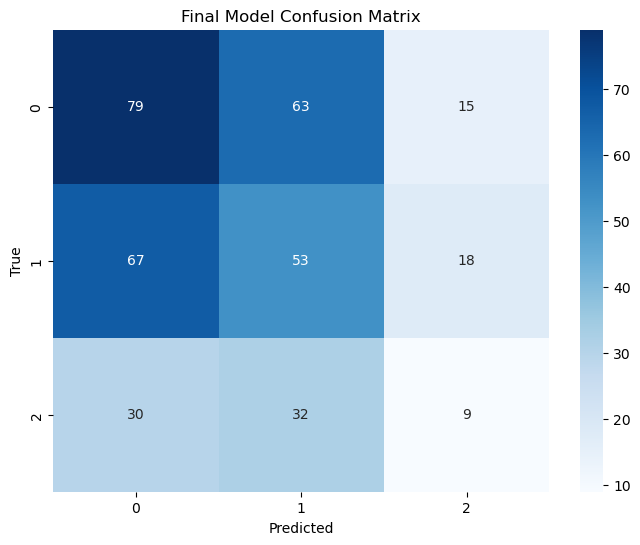

In [9]:
# Make predictions\n",
y_pred = best_model.predict(X_test)

# Print classification report\n",
print("Final Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
   
# Plot confusion matrix\n",
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Final Model Confusion Matrix')
plt.show()